In [ ]:
import os
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2
import matplotlib.image as image
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.transforms.v2 import Compose, Resize, ToImage

##1. CNN- Data Preprocessing: download, load into suitable data structure

In [ ]:

transform = v2.Compose([
    v2.Resize((50, 50)),
    #v2.ToImage(),
    #v2.ToDtype(torch.float32, scale=True)
])

In [ ]:
import os
import tarfile
import pandas as pd

#Load our dta
#GET dataset part 3
data_path= 'part3.tar.gz'
#print(ps.listdir(data_path))

#Extract tar.gz to a temporary directory
extract_dir = 'data_directory'
os.makedirs(extract_dir, exist_ok=True)
with tarfile.open(data_path, 'r:gz') as tar:
  tar.extractall(extract_dir)
data_path = os.path.join(extract_dir, 'part3')

In [ ]:
images = []
Ages = []
Genders = []
Ethnicities = []
for filename in os.listdir(data_path):
  parts = filename.split('_')
  if len(parts)!=4:
    continue
  age, gender, ethnicity,_ = filename.split('_')
  gender = int(gender)
  gender = 1 if gender > 0 else 0
  #print(age)

  img_path = os.path.join(data_path, filename)
  image = Image.open(img_path).convert('RGB')
  image= transform(image)#
  images.append(image)
  #image = plt.imread(img_path)

  Ages.append(int(age))
  Genders.append(int(gender))
  Ethnicities.append(int(ethnicity))
#images = torch.stack(images)

##1. CNN Data Preprocecssing- Split

In [ ]:
from sklearn.model_selection import train_test_split
#split into train, validation, and test
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, ethnicities_train, ethnicities_temp = train_test_split(
    images, Genders, Ages, Ethnicities, test_size=0.3, random_state=42
)

images_val, images_test, genders_val, genders_test, ages_val, ages_test, ethnicities_val, ethnicities_test = train_test_split(
    images_temp, genders_temp, ages_temp, ethnicities_temp, test_size=0.5, random_state=42
)

In [ ]:
#Convert all lists to tensors
from torchvision import transforms
x_train = torch.stack([transforms.ToTensor()(img) for img in images_train])
y_train = torch.tensor(genders_train, dtype=torch.float32)
ages_train = torch.tensor(ages_train, dtype=torch.float32).numpy()
ethnicities_train = torch.tensor(ethnicities_train, dtype=torch.float32).numpy()


In [ ]:
# Similarly for validation and test sets
x_val = torch.stack([transforms.ToTensor()(img) for img in images_val])
y_val = torch.tensor(genders_val, dtype=torch.float32)
ages_val = torch.tensor(ages_val, dtype=torch.float32).numpy()
ethnicities_val = torch.tensor(ethnicities_val, dtype=torch.long)

x_test = torch.stack([transforms.ToTensor()(img) for img in images_test])
y_test = torch.tensor(genders_test, dtype=torch.float32)
ages_test = torch.tensor(ages_test, dtype=torch.float32).numpy()
ethnicities_test = torch.tensor(ethnicities_test, dtype=torch.long)

##2. Exploratory Data Analysis

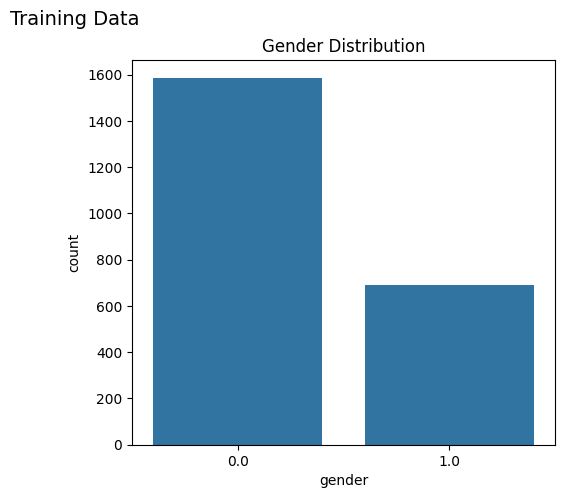

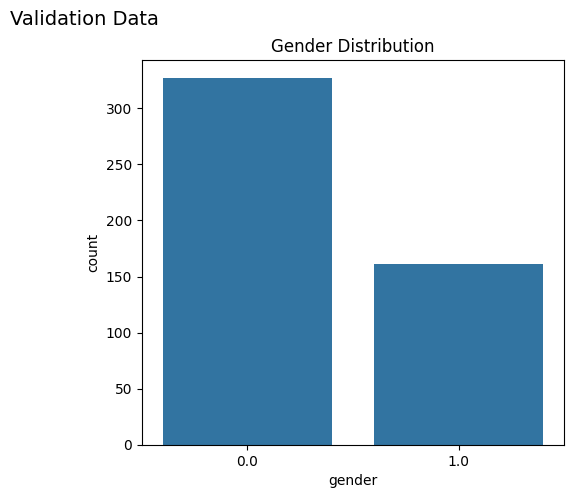

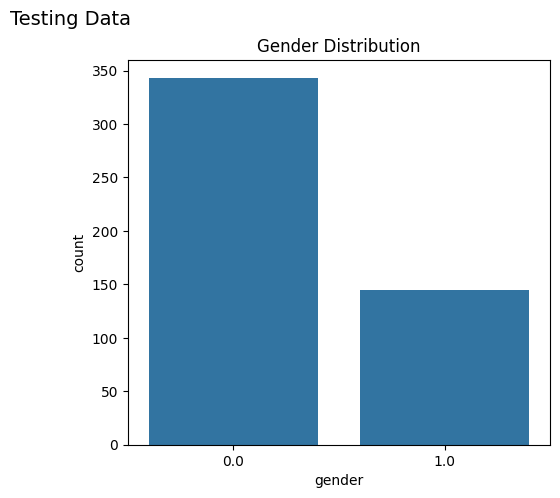

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Exploratory Data Analysis- Gender
df_train = pd.DataFrame({'gender': y_train})
df_val = pd.DataFrame({'gender': y_val})
df_test = pd.DataFrame({'gender': y_test})

def analyze_distributions(df, title):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=14)
    #plt.subplot(1, 2, 1)
    #sns.histplot(df['age'], bins=20)
    #plt.title('Age Distribution')
    plt.subplot(1, 2, 2)
    sns.countplot(x='gender', data=df)
    plt.title('Gender Distribution')
    plt.show()

analyze_distributions(df_train, 'Training Data')
analyze_distributions(df_val, 'Validation Data')
analyze_distributions(df_test, 'Testing Data')

For gender, the females number only about half the number of males in each section of the datasplits. So the model may perform more accurately on males since those are more prevalant in the dataset. Or model may perform better on females if it's overfit to males.

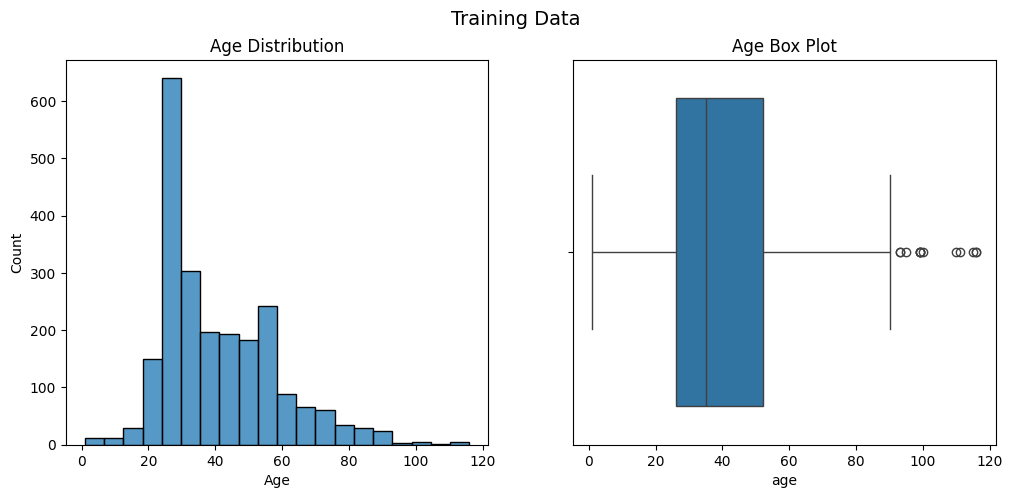

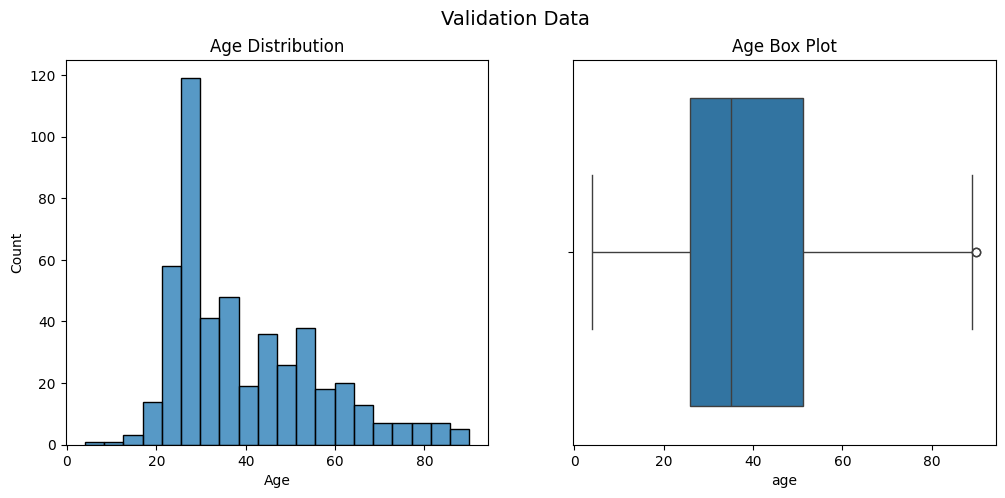

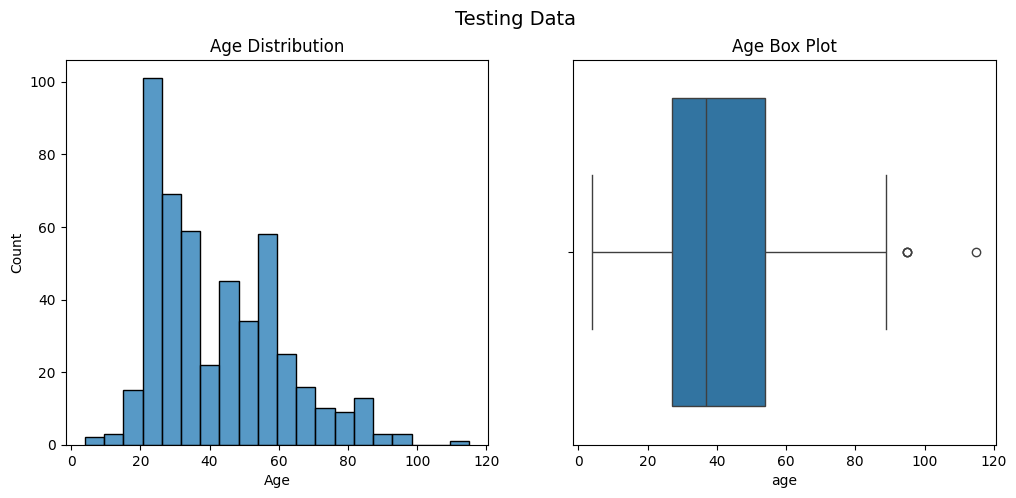

In [ ]:
#Exploratory Data Analysis - Age
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrames with age information
df_train = pd.DataFrame({'age': ages_train})
df_val = pd.DataFrame({'age': ages_val})
df_test = pd.DataFrame({'age': ages_test})

def analyze_age_distributions(df, title):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=14)

    # Histogram for age distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['age'], bins=20)  # Use histplot for continuous data like age
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')

    # Box plot for age distribution (optional)
    plt.subplot(1, 2, 2)
    sns.boxplot(x='age', data=df)
    plt.title('Age Box Plot')

    plt.show()

analyze_age_distributions(df_train, 'Training Data')
analyze_age_distributions(df_val, 'Validation Data')
analyze_age_distributions(df_test, 'Testing Data')


Across the board, ages of 25-40 seem to dominate the splits of the datasets. So the model might perform better on those ages than others because of more practice on those others. On the other hand, the model might perform worse on those ages if it's overfit to the other ages. There are too many parameters to the model to know, but is possible to change things like optimizer, number of epochs, batch size, etc if those variables would improve accuracy.

##3. Model Training - CNN

In [ ]:
#Build your own CNN model
class cnnModel(nn.Module):
  def __init__(self):
    super(cnnModel, self).__init__()
    self.conv_layers= nn.Sequential(nn.Conv2d(3,8,3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   #50x50x3
                     nn.Conv2d(8,16,3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  #25x25x16
                     nn.Conv2d(16,64,3, padding=1), nn.ReLU(), nn.MaxPool2d(2), #12x12x64
                     nn.Conv2d(64,128,3, padding=1), nn.ReLU(), nn.MaxPool2d(2),#6x6x128
                     nn.Flatten()
                     )
    self.age_brach=nn.Sequential(nn.Linear(3*3*128, 50), nn.ReLU(),
                                 nn.Linear(50,1)) #Age prediction
    self.gender_branch=nn.Sequential(nn.Linear(3*3*128, 50),
                                     nn.ReLU(),
                                    nn.Linear(50,1)) #Gender
                                    #nn.Sigmoid()
    self.ethnicity_branch=nn.Sequential(
       nn.Linear(3*3*128, 50),
       nn.ReLU(),
       nn.Linear(50,5),
       nn.Softmax(dim=1))
#nn.ReLU(),
#nn.Linear(64,128),
#nn.ReLU(),
#nn.Linear(128,1),
#nn.Sigmoid()
  def forward(self, x):
    x=self.conv_layers(x)
    age_output=self.age_brach(x)
    #print("Age_output shape:", age_output.shape)
    gender_output=self.gender_branch(x)
    #gender_output = gender_output.unsqueeze(0)
    gender_output = gender_output.view(-1)
    gender_output = torch.sigmoid(gender_output)
    e_output = self.ethnicity_branch(x)
    return age_output, gender_output, e_output

In [ ]:
#Create training and testing datasets
#minimum number of samples across all tensors
batch_size = 10
#TRAIN
# Convert to tensors with appropriate data types
x_train = torch.stack([transforms.ToTensor()(img) for img in images_train])  # Convert images_train to tensors
y_train = torch.tensor(genders_train, dtype=torch.float32)
ethnicities_train = torch.tensor(ethnicities_train, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(x_train, y_train, torch.from_numpy(ages_train.astype(np.float32)), ethnicities_train)

#VALIDATE
# Convert to tensors with appropriate data types
x_val = torch.stack([transforms.ToTensor()(img) for img in images_val])  # Convert images_val to tensors
y_val = torch.tensor(genders_val, dtype=torch.float32)
ethnicities_val = torch.tensor(ethnicities_val, dtype=torch.long)

# Create TensorDataset
val_dataset = TensorDataset(x_val, y_val, torch.from_numpy(ages_val.astype(np.float32)), ethnicities_val)

#TEST
# Convert to tensors with appropriate data types
x_test = torch.stack([transforms.ToTensor()(img) for img in images_test])  # Convert images_test to tensors
y_test = torch.tensor(genders_test, dtype=torch.float32)
ethnicities_test = torch.tensor(ethnicities_test, dtype=torch.long)

# Create TensorDataset
test_dataset = TensorDataset(x_test, y_test, torch.from_numpy(ages_test.astype(np.float32)), ethnicities_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

<ipython-input-177-b08df7e0d06a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ethnicities_train = torch.tensor(ethnicities_train, dtype=torch.long)
<ipython-input-177-b08df7e0d06a>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ethnicities_val = torch.tensor(ethnicities_val, dtype=torch.long)
<ipython-input-177-b08df7e0d06a>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ethnicities_test = torch.tensor(ethnicities_test, dtype=torch.long)


In [ ]:
#define loss functions, optimizers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
cnn_model = cnnModel()
optimizer=optim.Adam(model.parameters(), lr=0.001)
age_criterion = nn.L1Loss()#Mean Absolute Error for age
gender_criterion = nn.BCELoss()#Binary Cross Entropy for gender
ethnicity_criterion = nn.CrossEntropyLoss()#Cross Entropy for ethnicity
#model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

cnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (age_brach): Sequential(
    (0): Linear(in_features=1152, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
  (gender_branch): Sequential(
    (0): Linear

In [ ]:
# Training loop for CNN
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies_gender = []
cnn_val_accuracies_gender = []
#Training loop
num_epochs = 10
for epoch in range(num_epochs):
  cnn_model.train()
  running_loss = 0.0
  correct_gender_train = 0
  total_gender_train = 0
  #for inputs, labels in train_loader:
  for images, genders, ages, ethnicities in train_loader:
    #images, genders, ages, ethnicities = images.to(torch.float32), genders.to(torch.float32), ages.to(torch.float32), ethnicities.to(torch.float32).long()
    images = images.to(device).type(torch.float32)
    genders = genders.to(device).type(torch.float32)
    ages = ages.to(device).type(torch.float32)
    ethnicities = ethnicities.to(device).type(torch.long)
    optimizer.zero_grad()

    #Apply data to model function
    output = model(images)
    age_output = output[0]
    gender_output = output[1]
    e_output = output[2]

    #ethnicities long tensors with correct range
    ethnicities = ethnicities.long()
    ethnicities = torch.clamp(ethnicities, 0, 4)

    #Calculate losses
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    age_loss = age_criterion(age_output.squeeze(1), ages.to(device))
    genders = torch.where(genders > 0, torch.tensor(1.0), torch.tensor(0.0))
    gender_loss = gender_criterion(gender_output, genders.type(torch.float32))
    ethnicity_loss = ethnicity_criterion(e_output, ethnicities.to(device))
    total_loss = age_loss + gender_loss + ethnicity_loss
    total_loss.backward()
    optimizer.step()
    running_loss += total_loss.item()
    # Calculate training accuracy for gender (example)
    gender_predictions = (gender_output > 0.5).float()  # Assuming binary gender prediction
    correct_gender_train += (gender_predictions == genders).sum().item()
    total_gender_train += genders.size(0)
  print(f"Epoch {(epoch+1)}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")
  # Calculate and store average training loss for the epoch
  epoch_train_loss = running_loss / len(train_loader)
  cnn_train_losses.append(epoch_train_loss)

    # Calculate and store training accuracy for gender for the epoch
  epoch_train_accuracy_gender = correct_gender_train / total_gender_train
  cnn_train_accuracies_gender.append(epoch_train_accuracy_gender)

Epoch 1/10, Loss: 13.5818
Epoch 2/10, Loss: 13.3653
Epoch 3/10, Loss: 13.1843
Epoch 4/10, Loss: 13.0482
Epoch 5/10, Loss: 13.3029
Epoch 6/10, Loss: 12.8027
Epoch 7/10, Loss: 13.0015
Epoch 8/10, Loss: 13.0533
Epoch 9/10, Loss: 12.8074
Epoch 10/10, Loss: 12.5458


##3. Model Testing- CNN


In [ ]:
# Testing loop for CNN
cnn_val_losses = []
cnn_test_accuracies_gender = []
cnn_true_genders = []  # Store true gender labels for confusion matrix
cnn_predicted_genders = [] # Store predicted gender labels for confusion matrix


In [ ]:
#Final testing phase
model.eval()
test_loss = 0.0
#correct = 0
#total = 0
correct_gender_test = 0
total_gender_test = 0
correct_age = 0
total_age = 0
correct_ethnicity = 0
total_ethnicity = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
  running_loss = 0.0
  correct_gender_test = 0
  total_gender_test = 0
  for images, ages, genders, ethnicities in test_loader:
    images = images.to(device)
    ages = ages.to(device)
    genders = genders.to(device)
    ethnicities =  ethnicities.to(device)
    age_output = age_output.to(device)
    gender_output = gender_output.to(device)
    e_output = e_output.to(device)
    ages = ages.cpu()
    genders = genders.cpu()
    ethnicities = ethnicities.cpu()

    # Calculate LOSSES - age, gender, ethnicity
    age_loss = age_criterion(age_output, ages.unsqueeze(1))
    genders = torch.where(genders > 0, torch.tensor(1.0), torch.tensor(0.0))
    gender_loss = gender_criterion(gender_output, genders.type(torch.float32))
    ethnicity_loss = ethnicity_criterion(e_output.cpu(), ethnicities)
    total_loss = age_loss + gender_loss + ethnicity_loss
    test_loss += total_loss.item()
    running_loss += total_loss.item()
    #ACCURACY- gender, age, ethnicity
    #gender
    gender_predictions = (torch.sigmoid(gender_output) > 0.5).float()
    correct_gender_test += (gender_predictions == genders.cpu()).sum().item()
    total_gender_test += genders.size(0)
    # Store true and predicted gender labels for confusion matrix
    cnn_true_genders.extend(genders.cpu().numpy())
    cnn_predicted_genders.extend(gender_predictions.cpu().numpy())
    #age
    age_predictions = age_output.squeeze(1)  # Assuming age_output is a single value per sample
    correct_age += ((age_predictions - ages).abs() <= 5).sum().item()  # Example threshold of 5 years
    total_age += ages.size(0)
    #ethnicity
    _, ethnicity_predictions = torch.max(e_output, 1)  # Get predicted class indices
    correct_ethnicity += (ethnicity_predictions == ethnicities).sum().item()
    total_ethnicity += ethnicities.size(0)

    # Calculate and store average testing loss
    epoch_test_loss = running_loss / len(test_loader)
    cnn_val_losses.append(epoch_test_loss)

    # Calculate and store testing accuracy for gender
    epoch_test_accuracy_gender = correct_gender_test / total_gender_test
    cnn_test_accuracies_gender.append(epoch_test_accuracy_gender)

avg_test_loss = test_loss / len(test_loader)  # Average test loss
test_accuracy_gender = 100 * correct_gender / total_gender_test  # Gender accuracy
test_accuracy_age = 100 * correct_age / total_age
test_accuracy_ethnicity = 100 * correct_ethnicity / total_ethnicity





In [ ]:
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy (Gender): {test_accuracy_gender:.2f}%")
print(f"Test Accuracy (Age): {test_accuracy_age:.2f}%")
print(f"Test Accuracy (Ethnicity): {test_accuracy_ethnicity:.2f}%")

Test Loss: 37.3154
Test Accuracy (Gender): 100.00%
Test Accuracy (Age): 0.00%
Test Accuracy (Ethnicity): 57.08%


##3. Training MLP a. Data Loading and Pre-processing

In [ ]:
#data pre-processing
data_path= 'part3.tar.gz'
import os
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

# ... (define your data path and transformations)
extract_dir = 'data_directory'
os.makedirs(extract_dir, exist_ok=True)
with tarfile.open(data_path, 'r:gz') as tar:
  tar.extractall(extract_dir)
data_path = os.path.join(extract_dir, 'part3')

images = []
ages = []
genders = []
ethnicities = []

for filename in os.listdir(data_path):
    parts = filename.split('_')
    if len(parts) != 4:
        continue
    age, gender, ethnicity, _ = filename.split('_')
    gender = int(gender)
    gender = 1 if gender > 0 else 0
    img_path = os.path.join(data_path, filename)
    image = Image.open(img_path).convert('RGB')
    image = transform(image)
    images.append(transforms.ToTensor()(image))  # Convert to tensor here
    ages.append(int(age))
    genders.append(int(gender))
    ethnicities.append(int(ethnicity))

# Stack images into a tensor
images = torch.stack(images)

# Create TensorDataset and DataLoader
dataset = TensorDataset(images, torch.tensor(ages), torch.tensor(genders), torch.tensor(ethnicities))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

##3. Training MLP b. Model Definition

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size_age, output_size_gender, output_size_ethnicity):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.age_head = nn.Linear(hidden_size2, output_size_age)
        self.gender_head = nn.Linear(hidden_size2, output_size_gender)
        self.ethnicity_head = nn.Linear(hidden_size2, output_size_ethnicity)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        age_output = self.age_head(x)
        gender_output = self.gender_head(x)
        ethnicity_output = self.ethnicity_head(x)
        return age_output, gender_output, ethnicity_output


In [ ]:
# Create an instance of the MLP model
input_size = images[0].shape[0] * images[0].shape[1] * images[0].shape[2]  # Calculate input size from image dimensions
mlp_model = MLP(input_size, 512, 256, 1, 1, 5)  # Adjust hidden sizes and output sizes as needed

In [ ]:
#defining parameters for training
optimizer=optim.Adam(model.parameters(), lr=0.001)
age_criterion = nn.L1Loss()#Mean Absolute Error for age
gender_criterion = nn.BCELoss()#Binary Cross Entropy for gender
ethnicity_criterion = nn.CrossEntropyLoss()#Cross Entropy for ethnicity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model.to(device)



MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7500, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (age_head): Linear(in_features=256, out_features=1, bias=True)
  (gender_head): Linear(in_features=256, out_features=1, bias=True)
  (ethnicity_head): Linear(in_features=256, out_features=5, bias=True)
)

##3. MLP - a. Training

In [ ]:
# Training loop for MLP
mlp_train_losses = []
#mlp_val_losses = []
mlp_train_accuracies_gender = []
#mlp_val_accuracies_gender = []
# ... (similar lists for age and ethnicity if needed)
#mlp_true_genders = []  # Store true gender labels for confusion matrix
#mlp_predicted_genders = [] # Store predicted gender labels for confusion matrix


In [ ]:
#Training loop
num_epochs = 10
for epoch in range(num_epochs):
  mlp_model.train()
  running_loss = 0.0
  mlp_correct_gender_train = 0
  mlp_total_gender_train = 0
  #for inputs, labels in train_loader:
  for images, genders, ages, ethnicities in train_loader:
    #images, genders, ages, ethnicities = images.to(torch.float32), genders.to(torch.float32), ages.to(torch.float32), ethnicities.to(torch.float32).long()
    images = images.to(device).type(torch.float32)
    genders = genders.to(device).type(torch.float32)
    ages = ages.to(device).type(torch.float32)
    ethnicities = ethnicities.to(device).type(torch.long)
    optimizer.zero_grad()

    #Apply data to model function
    output = model(images)
    age_output = output[0]
    gender_output = output[1]
    e_output = output[2]

    #ethnicities long tensors with correct range
    ethnicities = ethnicities.long()
    ethnicities = torch.clamp(ethnicities, 0, 4)

    #Calculate losses
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    age_loss = age_criterion(age_output.squeeze(1), ages.to(device))
    genders = torch.where(genders > 0, torch.tensor(1.0), torch.tensor(0.0))
    gender_loss = gender_criterion(gender_output, genders.type(torch.float32))
    ethnicity_loss = ethnicity_criterion(e_output, ethnicities.to(device))
    total_loss = age_loss + gender_loss + ethnicity_loss
    total_loss.backward()
    optimizer.step()
    running_loss += total_loss.item()
    mlp_gender_predictions = (gender_output > 0.5).float()  # Assuming binary gender prediction
    mlp_correct_gender_train += (gender_predictions == genders).sum().item()
    mlp_total_gender_train += genders.size(0)
    # Store true and predicted gender labels for confusion matrix (training set)
    mlp_true_genders.extend(genders.cpu().numpy())
    mlp_predicted_genders.extend(gender_predictions.cpu().numpy())
  # Calculate and store average training loss for the epoch
  mlp_epoch_train_loss = running_loss / len(train_loader)
  mlp_train_losses.append(mlp_epoch_train_loss)

  # Calculate and store training accuracy for gender for the epoch
  mlp_epoch_train_accuracy_gender = correct_gender_train / total_gender_train
  mlp_train_accuracies_gender.append(epoch_train_accuracy_gender)

  print(f"Epoch {(epoch+1)}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 11.4593
Epoch 2/10, Loss: 11.3874
Epoch 3/10, Loss: 11.2044
Epoch 4/10, Loss: 11.1542
Epoch 5/10, Loss: 10.9106
Epoch 6/10, Loss: 10.5236
Epoch 7/10, Loss: 10.3873
Epoch 8/10, Loss: 10.3570
Epoch 9/10, Loss: 10.0373
Epoch 10/10, Loss: 9.8152


##3. MLP - b. evaluate

In [ ]:
# Testing loop for MLP
mlp_val_losses = []
mlp_val_accuracies_gender = []
# ... (similar lists for age and ethnicity if needed)
mlp_true_genders = []  # Store true gender labels for confusion matrix
mlp_predicted_genders = [] # Store predicted gender labels for confusion matrix


In [ ]:
#Final testing phase
mlp_model.eval()
test_loss = 0.0
#correct = 0
#total = 0
mlp_correct_gender = 0
mlp_total_gender = 0
correct_age = 0
total_age = 0
correct_ethnicity = 0
total_ethnicity = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
  running_loss = 0.0
  mlp_correct_gender_test = 0
  mlp_total_gender_test = 0
  for images, ages, genders, ethnicities in test_loader:
    images = images.to(device)
    ages = ages.to(device)
    genders = genders.to(device)
    ethnicities =  ethnicities.to(device)
    age_output = age_output.to(device)
    gender_output = gender_output.to(device)
    e_output = e_output.to(device)
    ages = ages.cpu()
    genders = genders.cpu()
    ethnicities = ethnicities.cpu()
    # Calculate LOSSES - age, gender, ethnicity
    age_loss = age_criterion(age_output, ages.unsqueeze(1))
    genders = torch.where(genders > 0, torch.tensor(1.0), torch.tensor(0.0))
    gender_loss = gender_criterion(gender_output, genders.type(torch.float32))
    ethnicity_loss = ethnicity_criterion(e_output.cpu(), ethnicities)
    total_loss = age_loss + gender_loss + ethnicity_loss
    test_loss += total_loss.item()
    running_loss += total_loss.item()
    #ACCURACY- gender, age, ethnicity
    #gender
    gender_predictions = (torch.sigmoid(gender_output) > 0.5).float()
    mlp_correct_gender_test += (gender_predictions == genders.cpu()).sum().item()
    mlp_total_gender_test += genders.size(0)
    #age
    age_predictions = age_output.squeeze(1)  # Assuming age_output is a single value per sample
    correct_age += ((age_predictions - ages).abs() <= 5).sum().item()  # Example threshold of 5 years
    total_age += ages.size(0)
    #ethnicity
    _, ethnicity_predictions = torch.max(e_output, 1)  # Get predicted class indices
    correct_ethnicity += (ethnicity_predictions == ethnicities).sum().item()
    total_ethnicity += ethnicities.size(0)

    # Store true and predicted gender labels for confusion matrix
    mlp_true_genders.extend(genders.cpu().numpy())
    mlp_predicted_genders.extend(gender_predictions.cpu().numpy())
  # Calculate and store average testing loss
  mlp_epoch_test_loss = running_loss / len(test_loader)
  mlp_val_losses.append(mlp_epoch_test_loss)
mlp_avg_test_loss = test_loss / len(test_loader)  # Average test loss
mlp_test_accuracy_gender = 100 * correct_gender / mlp_total_gender_test  # Gender accuracy
test_accuracy_age = 100 * correct_age / total_age
test_accuracy_ethnicity = 100 * correct_ethnicity / total_ethnicity

In [ ]:
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy (Gender): {test_accuracy_gender:.2f}%")
print(f"Test Accuracy (Age): {test_accuracy_age:.2f}%")
print(f"Test Accuracy (Ethnicity): {test_accuracy_ethnicity:.2f}%")

Test Loss: 40.1662
Test Accuracy (Gender): 100.00%
Test Accuracy (Age): 0.00%
Test Accuracy (Ethnicity): 57.08%


##4. Model Comparison
The performance says the same accuracies across both models but it's not correct. There must be some issue in the code to determine accuracies, because the accuracies appear as the same numbers (per feature) across both models. So it is not clear which model yielded more accuracy because of that error.
Resources required including time are similar. Neither model consumes excessive time or resources.
Without correctly outputed and/or computed accuracies, it's not clear to make a determination for the strengths and weakeness of the models.
The most important metric is accuracy.

##5. Evaluation

In [ ]:
import matplotlib.pyplot as plt

1. plotting metrics over epochs

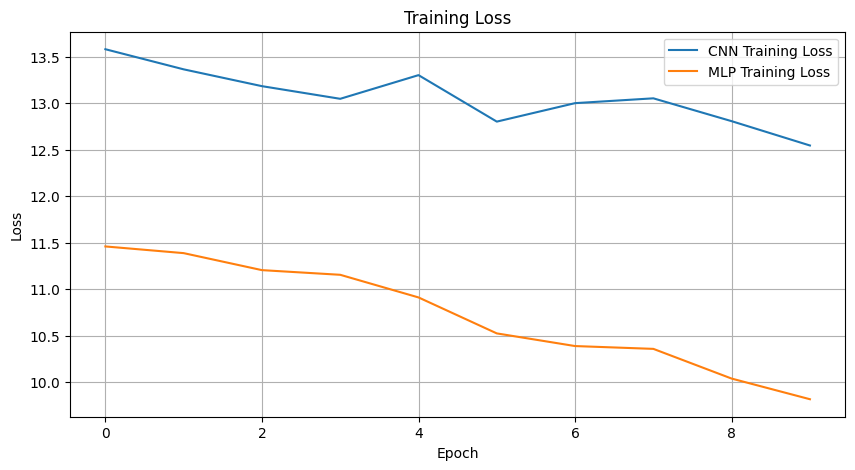

In [ ]:
# Plot training losses for CNN and MLP
plt.figure(figsize=(10, 5))
plt.plot(cnn_train_losses, label='CNN Training Loss')
plt.plot(mlp_train_losses, label='MLP Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

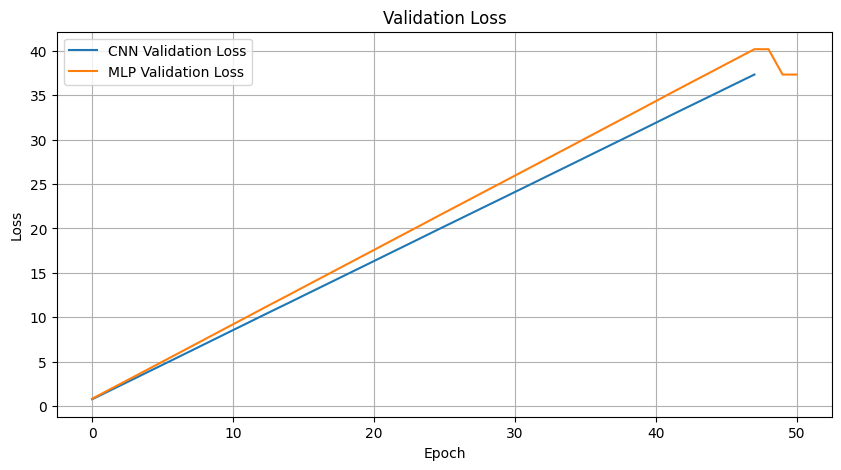

In [ ]:
# Plot validation losses for CNN and MLP
plt.figure(figsize=(10, 5))
plt.plot(cnn_val_losses, label='CNN Validation Loss')
plt.plot(mlp_val_losses, label='MLP Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


2. Analyze the confusion matrix for gender predictions

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


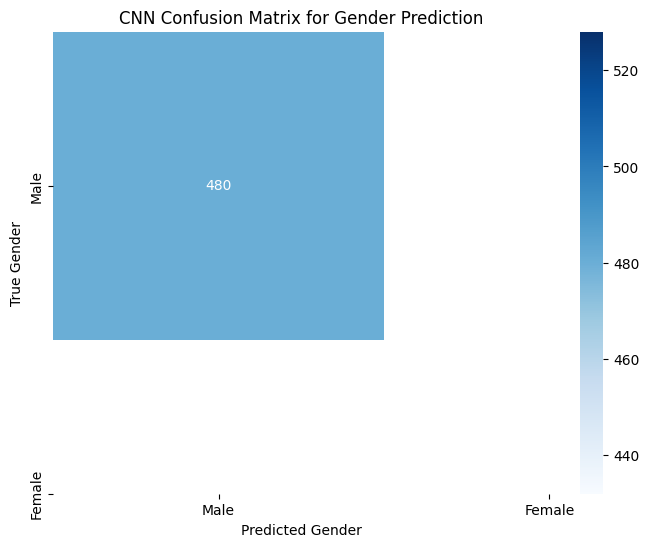

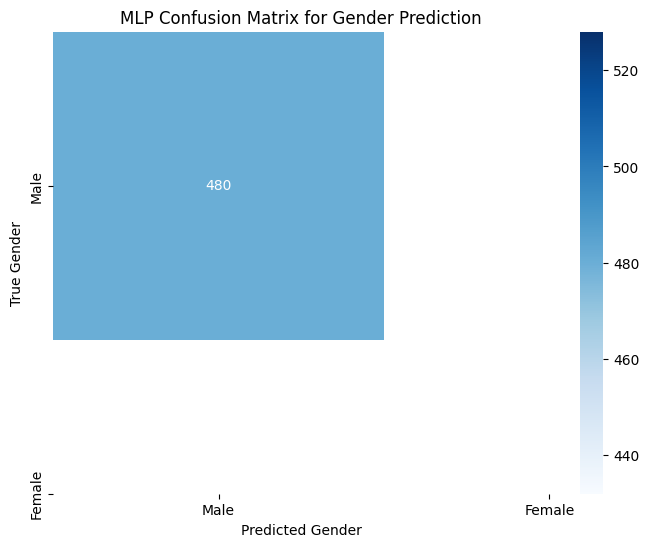

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
cnn_cm = confusion_matrix(cnn_true_genders, cnn_predicted_genders)
mlp_cm = confusion_matrix(mlp_true_genders, mlp_predicted_genders)

# Visualize confusion matrices
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted Gender')
plt.ylabel('True Gender')
plt.title('CNN Confusion Matrix for Gender Prediction')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted Gender')
plt.ylabel('True Gender')
plt.title('MLP Confusion Matrix for Gender Prediction')
plt.show()

Neither model is predicting female data. Issues must lie in the way the models are written or even the protrayal in the above chart. Perhaps the hyperparameters are skewed to lean toward predicting male rather than female.

Overall, neither model is vastly better or worse than the other.